These functions will help you extract the entire report and place them into a pandas dataframe - please remember to download the conversion table (dow 30 to cik #):
1) getting_crawler(year_number, qtr): this function will download the index file as provdied by sec.gov. Please indicate the year as well the quarter you would like to extract the data from. For more information, visit https://www.sec.gov/edgar/searchedgar/accessing-edgar-data.htm

2) milestone_search(file_name): milestone_search looks for where the listing begins in the index file.

3) convert_to_pandas(file_name, data_start): convert_to_pandas function converts index file to a pandas data frame

4) search_company_name(data, company_name, report_type): allows you to find the url for the report as well as the the specified companies. Please note that the function currently only take CIK# for accuracy. Many larger companies have multiple reporting sub-companies, i.e., J P Morgan.

5) getting_data(url_list, year_number, qtr, report_type): Will download the entire webpage of the report as a file and put it into a pandas dataframe. For missing values, it will automatically assigned np.NaN

6) adding_company_name(data): will add company name and other inforamtion back to the current dataframe

7) putting_together(year_number,qtr, company_name, report_type): goes through the entire process and only return the data_frame with the full data.

8) the functions now support saving and reading in pickle files!

9) converting company tickers to ciks - there is a function that will search for cik using the tickers on sec.gov

See below listing for the options for company_name

In [2]:
import urllib
import pandas as pd
import struct
import numpy as np
from bs4 import BeautifulSoup
import requests
import regex as re
import pickle
import os.path
import datetime
import spacy
import string
import bs4

In [4]:
sp500 = pd.read_csv("sp500.csv")

In [7]:
sp500.head(2)

,Ticker symbol,Security,SEC filings,GICS?Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,A,Agilent Technologies Inc,reports,Health Care,Health Care Equipment,"Santa Clara, California",2000-06-05,1090872
1,AAL,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",2015-03-23,6201


In [10]:
new = sp500[["Ticker symbol","Security","CIK"]]

In [16]:
new = new.rename(columns={"Ticker symbol":"Company","Security":"Name","CIK":"CIK #"})

In [17]:
new.to_csv("sp500_new.csv")

In [3]:
company_table = pd.read_csv("cik_list.csv")

In [4]:
company_table.head(3)

,Company,Name,CIK #
0,AAPL,Apple Inc.,320193
1,AXP,American Expression Co.,4962
2,BA,Boeing Co.,12927


In [34]:
cik_lookup = pd.read_table("cik_look_up.txt",names = ["company"])

In [35]:
cik_lookup.head(5)

,company
0,!J INC:0001438823:
1,"#1 A LIFESAFER HOLDINGS, INC.:0001509607:"
2,#1 ARIZONA DISCOUNT PROPERTIES LLC:0001457512:
3,#1 PAINTBALL CORP:0001433777:
4,$ LLC:0001427189:


In [36]:
def clean_up(pattern, x):
    if not re.match(pattern, x):
        return np.NaN
    else:
        return re.match(pattern, x).group(1).lower()

In [37]:
cik_lookup.loc[:,"Name"] = cik_lookup["company"].apply(lambda x: clean_up("(.+):\d+:",x))

In [38]:
cik_lookup.loc[:,"cik #"] = cik_lookup["company"].apply(lambda x: clean_up(".+:(\d+):",x))

In [39]:
cik_lookup.head(3)

,company,Name,cik #
0,!J INC:0001438823:,!j inc,0001438823
1,"#1 A LIFESAFER HOLDINGS, INC.:0001509607:","#1 a lifesafer holdings, inc.",0001509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC:0001457512:,#1 arizona discount properties llc,0001457512


In [60]:
def stripping_0(x):
    if not x:
        return np.NaN
    elif type(x) != str:
        x = str(x)
        return re.sub("^0+","",x)
    else:
        return re.sub("^0+","",x)

In [41]:
stripping_0(cik_lookup.loc[0,"cik #"])
type(cik_lookup.loc[0,"cik #"])

str

In [42]:
cik_lookup["CIK #"] = cik_lookup["cik #"].apply(lambda x: stripping_0(x))

In [43]:
cik_lookup.head(5)

,company,Name,cik #,CIK #
0,!J INC:0001438823:,!j inc,0001438823,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.:0001509607:","#1 a lifesafer holdings, inc.",0001509607,1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC:0001457512:,#1 arizona discount properties llc,0001457512,1457512
3,#1 PAINTBALL CORP:0001433777:,#1 paintball corp,0001433777,1433777
4,$ LLC:0001427189:,$ llc,0001427189,1427189


In [44]:
cik_lookup.shape

(661046, 4)

In [45]:
cik_nm = cik_lookup.dropna().reset_index(drop=True)

In [46]:
cik_nm.shape[0]

661042

In [511]:
cik_nm.to_csv("cik_nm.csv",index=False)
#cik_nm.to_pickle("cik_nm.txt")

In [12]:
def getting_crawler(year_number,qtr):
    base_url = "https://www.sec.gov/Archives/edgar/full-index/"
    year = str(year_number) + "/"
    if qtr == 1:
        QTR = "QTR1/"
    if qtr == 2:
        QTR = "QTR2/"
    if qtr == 3:
        QTR = "QTR3/"
    if qtr == 4:
        QTR = "QTR4/"
    download_file = "crawler.idx"
    full = base_url + year + QTR + download_file
    file_name = str(year_number) + "_QTR" + str(qtr) + "_crawler.idx"
    testfile = urllib.URLopener()
    testfile.retrieve(full, file_name)
    return file_name

In [13]:
def milestone_search(file_name):
    with open(file_name) as myFile:
        for num, line in enumerate(myFile, 0):
            if ("CIK" in line):
                if ("Form Type" in line):
                    #print 'found at line:', num
                    line_start = num
            if "------------------" in line:
                #print "found ----- at line:", num
                data_start = num+1
                #print "data starts at:", data_start
    return data_start

In [14]:
def convert_to_pandas(file_name, data_start):
    company_name = list()
    report_type = list()
    CIK = list()
    date = list()
    url = list()
    with open(file_name) as myfile:
        testing = myfile.readlines()[data_start:]
        for record in testing:
            record_split = map(lambda x: x.strip(), filter(lambda x: x!="" and x !="\n" and x != " \n", record.split("  ")))
            if len(record_split) < 5:
                continue
            else:
                company_name.append(record_split[0])
                report_type.append(record_split[1])
                CIK.append(record_split[2])
                date.append(record_split[3])
                url.append(record_split[4])
    data_dict = {"company":company_name,
                 "report":report_type,
                 "CIK":CIK,
                 "date":date,
                 "url":url}
    df = pd.DataFrame.from_dict(data_dict)
    df["company_l"] = df["company"].str.lower()
    return df

In [15]:
def search_company_name(data, company_name, report_type):
    data_report = data[data["report"] == report_type]
    company_table = pd.read_csv(company_name)
    company_table = company_table[["Name","CIK #"]]
    company_table["CIK #"] = company_table["CIK #"].astype(str)
    result = pd.merge(data_report, company_table, how ='inner', left_on = "CIK", right_on = "CIK #")
    result = result[["Name", "CIK #", "company", "report", "date", "url"]].reset_index(drop=True)
    return result

In [16]:
def getting_data(company_list, year_number, qtr, report_type):
    for i in range(0, company_list.shape[0]):
        url_address = company_list.loc[i,"url"]
        text = requests.get(url_address).text
        text = BeautifulSoup(text, "html.parser")
        target = text.find("table",{"class":"tableFile"})
        link = target.find_all("tr")[1].find_all("a")[0]["href"]
        final_link = "https://www.sec.gov"+link
        text_report = requests.get(final_link).text
        text_report = BeautifulSoup(text_report, "html.parser")
        content = text_report.text
        content = content.encode(encoding='UTF-8')
        company_list.loc[i,"full_text"] = content
    company_list["year"] = year_number
    company_list["quarter"] = qtr
    company_list["report_type"] = report_type
    return company_list

In [59]:
def putting_together(year_number, qtr, company_name, report_type, runtime=True):
    start = datetime.datetime.now()
    file_path = str(year_number) + "_QTR" + str(qtr) + "_crawler.idx"
    if not os.path.isfile(file_path):
        file_path = getting_crawler(year_number,qtr)
        print "downloaded idx file"
    print "file already exist"
    data_start_num = milestone_search(file_path)
    data_frame = convert_to_pandas(file_path, data_start_num)
    results = search_company_name(data_frame, company_name, report_type)
    final_data = getting_data(results, year_number, qtr, report_type)
    end = datetime.datetime.now()
    final_data["date"] = pd.to_datetime(final_data["date"])
    print "DataFrame rows: " + str(final_data.shape[0])
    if runtime:
        print end - start
    return final_data

# Saving the final_dataset to a pickle file, and reading in a pickle file

In [18]:
def save_as_pickle(path_to_save, final_data):
    final_data.to_pickle(path_to_save)

In [19]:
def read_data(path_to_open):
    infile = open(path_to_open,"rb")
    newdata = pickle.load(infile)
    infile.close()
    return newdata

getting CIK # from tickers

In [53]:
_CIK_API_URI = 'http://www.sec.gov/cgi-bin/browse-edgar' \
           '?action=getcompany&CIK={s}&count=10&output=xml'

def get_cik(symbol):
    response = requests.get(_CIK_API_URI.format(s=symbol))
    page_data = bs4.BeautifulSoup(response.text, "html.parser")
    if page_data.companyinfo is None:
        return np.NaN
    else:
        cik = page_data.companyinfo.cik.string
        return cik
        print symbol, cik

# Demonstration - extracting the latest document for all 30 companies

In [28]:
data_2017_qrt2 = putting_together(2017, 2, "sp500_new.csv","10-K")

DataFrame rows: 16
0:00:59.182327


In [29]:
data_2017_qrt1 = putting_together(2017, 1, "sp500_new.csv","10-K")

DataFrame rows: 401
0:32:35.485005


In [30]:
data_2016_qrt4 = putting_together(2016, 4, "sp500_new.csv","10-K")

DataFrame rows: 44
0:02:42.324531


In [31]:
data_2016_qrt3 = putting_together(2016, 3, "sp500_new.csv","10-K")

DataFrame rows: 29
0:01:44.636659


In [32]:
latest_sp500 = data_2017_qrt2.append([data_2017_qrt1, data_2016_qrt4, data_2016_qrt3]).reset_index(drop=True)

In [34]:
latest_sp500.to_csv("latest_sp500.csv",index=False)

In [127]:
#final.groupby(by ="CIK #")["Name"].agg("count")
final[(final["CIK #"]== "806085") & (final["year"]==2007)]

,CIK #,Name,company,date,full_text,quarter,report,report_type,url,year
20,806085,Lehman Brothers,LEHMAN BROTHERS HOLDINGS INC,2007-02-13,\n10-K\n1\na07-4192_110k.htm\n10-K\n\n\n\n\n\n...,1,10-K,10-K,https://www.sec.gov/Archives/edgar/data/806085...,2007


In [277]:
final.head(3)

NameError: name 'final' is not defined

Downloading all idx files to create a database for all report from year 2000 to 2017 qtr2 to facilitate data extraction

In [94]:
def download(year_number, qtr, runtime=True):
    start = datetime.datetime.now()
    file_path = str(year_number) + "_QTR" + str(qtr) + "_crawler.idx"
    if not os.path.isfile(file_path):
        file_path = getting_crawler(year_number,qtr)
        print "downloaded idx file"
    else:
        print "file already exists"
    if runtime:
        end = datetime.datetime.now()
        print "total runtime: " + str(end-start)

In [239]:
def create_idx(year_number, qtr):
    file_path = str(year_number) + "_QTR" + str(qtr) + "_crawler.idx"
    data_start_num = milestone_search(file_path)
    data_frame = convert_to_pandas(file_path, data_start_num)
    data_frame["year"] = year_number
    data_frame["qtr"] = qtr
    return data_frame

In [240]:
download(2017, 1)
download(2017, 2)
idx_2017_qtr1 = create_idx(2017, 1)
idx_2017_qtr2 = create_idx(2017, 2)

file already exists
total runtime: 0:00:00.000152
file already exists
total runtime: 0:00:00.000114


In [241]:
download(2016,4)
download(2016,3)
download(2016,2)
download(2016,1)
idx_2016_qtr4 = create_idx(2016, 4)
idx_2016_qtr3 = create_idx(2016, 3)
idx_2016_qtr2 = create_idx(2016, 2)
idx_2016_qtr1 = create_idx(2016, 1)

file already exists
total runtime: 0:00:00.000176
file already exists
total runtime: 0:00:00.000167
file already exists
total runtime: 0:00:00.000204
file already exists
total runtime: 0:00:00.000040


In [242]:
download(2015,4)
download(2015,3)
download(2015,2)
download(2015,1)
idx_2015_qtr4 = create_idx(2015, 4)
idx_2015_qtr3 = create_idx(2015, 3)
idx_2015_qtr2 = create_idx(2015, 2)
idx_2015_qtr1 = create_idx(2015, 1)

file already exists
total runtime: 0:00:00.000544
file already exists
total runtime: 0:00:00.000073
file already exists
total runtime: 0:00:00.000048
file already exists
total runtime: 0:00:00.000044


In [243]:
download(2014,4)
download(2014,3)
download(2014,2)
download(2014,1)
idx_2014_qtr4 = create_idx(2014, 4)
idx_2014_qtr3 = create_idx(2014, 3)
idx_2014_qtr2 = create_idx(2014, 2)
idx_2014_qtr1 = create_idx(2014, 1)

file already exists
total runtime: 0:00:00.000187
file already exists
total runtime: 0:00:00.000146
file already exists
total runtime: 0:00:00.000051
file already exists
total runtime: 0:00:00.000040


In [244]:
download(2013,4)
download(2013,3)
download(2013,2)
download(2013,1)
idx_2013_qtr4 = create_idx(2013, 4)
idx_2013_qtr3 = create_idx(2013, 3)
idx_2013_qtr2 = create_idx(2013, 2)
idx_2013_qtr1 = create_idx(2013, 1)

file already exists
total runtime: 0:00:00.000130
file already exists
total runtime: 0:00:00.000052
file already exists
total runtime: 0:00:00.000039
file already exists
total runtime: 0:00:00.000053


In [245]:
download(2012,4)
download(2012,3)
download(2012,2)
download(2012,1)
idx_2012_qtr4 = create_idx(2012, 4)
idx_2012_qtr3 = create_idx(2012, 3)
idx_2012_qtr2 = create_idx(2012, 2)
idx_2012_qtr1 = create_idx(2012, 1)

file already exists
total runtime: 0:00:00.000127
file already exists
total runtime: 0:00:00.000051
file already exists
total runtime: 0:00:00.000041
file already exists
total runtime: 0:00:00.000039


In [246]:
download(2011,4)
download(2011,3)
download(2011,2)
download(2011,1)
idx_2011_qtr4 = create_idx(2011, 4)
idx_2011_qtr3 = create_idx(2011, 3)
idx_2011_qtr2 = create_idx(2011, 2)
idx_2011_qtr1 = create_idx(2011, 1)

file already exists
total runtime: 0:00:00.000148
file already exists
total runtime: 0:00:00.000053
file already exists
total runtime: 0:00:00.000040
file already exists
total runtime: 0:00:00.000037


In [247]:
download(2010,4)
download(2010,3)
download(2010,2)
download(2010,1)
idx_2010_qtr4 = create_idx(2010, 4)
idx_2010_qtr3 = create_idx(2010, 3)
idx_2010_qtr2 = create_idx(2010, 2)
idx_2010_qtr1 = create_idx(2010, 1)

file already exists
total runtime: 0:00:00.000255
file already exists
total runtime: 0:00:00.000091
file already exists
total runtime: 0:00:00.000042
file already exists
total runtime: 0:00:00.000096


In [248]:
download(2009,4)
download(2009,3)
download(2009,2)
download(2009,1)
idx_2009_qtr4 = create_idx(2009, 4)
idx_2009_qtr3 = create_idx(2009, 3)
idx_2009_qtr2 = create_idx(2009, 2)
idx_2009_qtr1 = create_idx(2009, 1)

file already exists
total runtime: 0:00:00.000121
file already exists
total runtime: 0:00:00.000047
file already exists
total runtime: 0:00:00.000041
file already exists
total runtime: 0:00:00.000037


In [249]:
download(2008,4)
download(2008,3)
download(2008,2)
download(2008,1)
idx_2008_qtr4 = create_idx(2008, 4)
idx_2008_qtr3 = create_idx(2008, 3)
idx_2008_qtr2 = create_idx(2008, 2)
idx_2008_qtr1 = create_idx(2008, 1)

file already exists
total runtime: 0:00:00.000137
file already exists
total runtime: 0:00:00.000041
file already exists
total runtime: 0:00:00.000035
file already exists
total runtime: 0:00:00.000037


In [250]:
download(2007,4)
download(2007,3)
download(2007,2)
download(2007,1)
idx_2007_qtr4 = create_idx(2007, 4)
idx_2007_qtr3 = create_idx(2007, 3)
idx_2007_qtr2 = create_idx(2007, 2)
idx_2007_qtr1 = create_idx(2007, 1)

file already exists
total runtime: 0:00:00.000122
file already exists
total runtime: 0:00:00.000048
file already exists
total runtime: 0:00:00.000040
file already exists
total runtime: 0:00:00.000039


In [251]:
download(2006,4)
download(2006,3)
download(2006,2)
download(2006,1)
idx_2006_qtr4 = create_idx(2006, 4)
idx_2006_qtr3 = create_idx(2006, 3)
idx_2006_qtr2 = create_idx(2006, 2)
idx_2006_qtr1 = create_idx(2006, 1)

file already exists
total runtime: 0:00:00.000229
file already exists
total runtime: 0:00:00.000051
file already exists
total runtime: 0:00:00.000037
file already exists
total runtime: 0:00:00.000037


In [252]:
download(2005,4)
download(2005,3)
download(2005,2)
download(2005,1)
idx_2005_qtr4 = create_idx(2005, 4)
idx_2005_qtr3 = create_idx(2005, 3)
idx_2005_qtr2 = create_idx(2005, 2)
idx_2005_qtr1 = create_idx(2005, 1)

file already exists
total runtime: 0:00:00.000549
file already exists
total runtime: 0:00:00.000058
file already exists
total runtime: 0:00:00.000040
file already exists
total runtime: 0:00:00.000037


In [253]:
download(2004,4)
download(2004,3)
download(2004,2)
download(2004,1)
idx_2004_qtr4 = create_idx(2004, 4)
idx_2004_qtr3 = create_idx(2004, 3)
idx_2004_qtr2 = create_idx(2004, 2)
idx_2004_qtr1 = create_idx(2004, 1)

file already exists
total runtime: 0:00:00.000118
file already exists
total runtime: 0:00:00.000055
file already exists
total runtime: 0:00:00.000054
file already exists
total runtime: 0:00:00.000048


In [254]:
download(2003,4)
download(2003,3)
download(2003,2)
download(2003,1)
idx_2003_qtr4 = create_idx(2003, 4)
idx_2003_qtr3 = create_idx(2003, 3)
idx_2003_qtr2 = create_idx(2003, 2)
idx_2003_qtr1 = create_idx(2003, 1)

file already exists
total runtime: 0:00:00.000119
file already exists
total runtime: 0:00:00.000048
file already exists
total runtime: 0:00:00.000042
file already exists
total runtime: 0:00:00.000038


In [255]:
download(2002,4)
download(2002,3)
download(2002,2)
download(2002,1)
idx_2002_qtr4 = create_idx(2002, 4)
idx_2002_qtr3 = create_idx(2002, 3)
idx_2002_qtr2 = create_idx(2002, 2)
idx_2002_qtr1 = create_idx(2002, 1)

file already exists
total runtime: 0:00:00.000116
file already exists
total runtime: 0:00:00.000043
file already exists
total runtime: 0:00:00.000037
file already exists
total runtime: 0:00:00.001303


In [256]:
download(2001,4)
download(2001,3)
download(2001,2)
download(2001,1)
idx_2001_qtr4 = create_idx(2001, 4)
idx_2001_qtr3 = create_idx(2001, 3)
idx_2001_qtr2 = create_idx(2001, 2)
idx_2001_qtr1 = create_idx(2001, 1)

file already exists
total runtime: 0:00:00.000124
file already exists
total runtime: 0:00:00.000050
file already exists
total runtime: 0:00:00.000043
file already exists
total runtime: 0:00:00.000038


In [257]:
download(2000,4)
download(2000,3)
download(2000,2)
download(2000,1)
idx_2000_qtr4 = create_idx(2000, 4)
idx_2000_qtr3 = create_idx(2000, 3)
idx_2000_qtr2 = create_idx(2000, 2)
idx_2000_qtr1 = create_idx(2000, 1)

file already exists
total runtime: 0:00:00.000110
file already exists
total runtime: 0:00:00.000040
file already exists
total runtime: 0:00:00.000038
file already exists
total runtime: 0:00:00.000038


In [137]:
listing = [idx_2017_qtr2, idx_2017_qtr1, idx_2016_qtr4, idx_2016_qtr3, idx_2016_qtr2, idx_2016_qtr1,
          idx_2015_qtr4, idx_2015_qtr3, idx_2015_qtr2, idx_2015_qtr1, 
           idx_2014_qtr4, idx_2014_qtr3, idx_2014_qtr2, idx_2014_qtr1,
          idx_2013_qtr4, idx_2013_qtr3, idx_2013_qtr2, idx_2013_qtr1,
          idx_2012_qtr4, idx_2012_qtr3, idx_2012_qtr2, idx_2012_qtr1,
          idx_2011_qtr4, idx_2011_qtr3, idx_2011_qtr2, idx_2011_qtr1,
          idx_2010_qtr4, idx_2010_qtr3, idx_2010_qtr2, idx_2010_qtr1,
          idx_2009_qtr4, idx_2009_qtr3, idx_2009_qtr2, idx_2009_qtr1,
          idx_2008_qtr4, idx_2008_qtr3, idx_2008_qtr2, idx_2008_qtr1,
          idx_2007_qtr4, idx_2007_qtr3, idx_2007_qtr2, idx_2007_qtr1,
           idx_2006_qtr4, idx_2006_qtr3, idx_2006_qtr2, idx_2006_qtr1,
          idx_2005_qtr4, idx_2005_qtr3, idx_2005_qtr2, idx_2005_qtr1,
          idx_2004_qtr4, idx_2004_qtr3, idx_2004_qtr2, idx_2004_qtr1,
          idx_2003_qtr4, idx_2003_qtr3, idx_2003_qtr2, idx_2003_qtr1,
          idx_2002_qtr4, idx_2002_qtr3, idx_2002_qtr2, idx_2002_qtr1,
          idx_2001_qtr4, idx_2001_qtr3, idx_2001_qtr2, idx_2001_qtr1,
          idx_2000_qtr4, idx_2000_qtr3, idx_2000_qtr2, idx_2000_qtr1]

In [716]:
all_listing = pd.concat(listing, axis=0)

In [717]:
all_listing.shape

(15246085, 6)

In [718]:
all_listing.head(5)

,CIK,company,date,report,url,company_l
0,1703629,'Ohana Labs Inc.,2017-04-12,D,https://www.sec.gov/Archives/edgar/data/170362...,'ohana labs inc.
1,1307969,"024 Pharma, Inc.",2017-04-11,10-Q,https://www.sec.gov/Archives/edgar/data/130796...,"024 pharma, inc."
2,1307969,"024 Pharma, Inc.",2017-05-11,10-Q/A,https://www.sec.gov/Archives/edgar/data/130796...,"024 pharma, inc."
3,1084869,1 800 FLOWERS COM INC,2017-05-12,10-Q,https://www.sec.gov/Archives/edgar/data/108486...,1 800 flowers com inc
4,1084869,1 800 FLOWERS COM INC,2017-05-24,4,https://www.sec.gov/Archives/edgar/data/108486...,1 800 flowers com inc


In [719]:
all_listing["company"] = all_listing["company"].apply(lambda y: re.sub("'","",y))

In [720]:
cleaned = all_listing.reset_index(drop=True)

In [721]:
def find_text(x):
    if re.search("\d{4}-\d{2}-\d{2}",x):
        return 1
    else:
        return 0

In [723]:
cleaned.columns

Index([u'CIK', u'company', u'date', u'report', u'url', u'company_l'], dtype='object')

In [724]:
cleaned["date_clean"] = cleaned["date"].apply(lambda y: find_text(y))

In [725]:
cleaned["date_clean"].value_counts()

1    15170492
0       75593
Name: date_clean, dtype: int64

In [726]:
cleaned = cleaned[cleaned["date_clean"]==1]

In [727]:
cleaned["date"] = pd.to_datetime(cleaned["date"],format = "%Y-%m-%d")

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [729]:
cleaned["year"] = cleaned["date"].apply(lambda z: z.year)

In [730]:
cleaned[cleaned["report"]=="10-K"].shape

(144032, 8)

In [731]:
cleaned.head(4)

,CIK,company,date,report,url,company_l,date_clean,year
0,1703629,Ohana Labs Inc.,2017-04-12,D,https://www.sec.gov/Archives/edgar/data/170362...,'ohana labs inc.,1,2017
1,1307969,"024 Pharma, Inc.",2017-04-11,10-Q,https://www.sec.gov/Archives/edgar/data/130796...,"024 pharma, inc.",1,2017
2,1307969,"024 Pharma, Inc.",2017-05-11,10-Q/A,https://www.sec.gov/Archives/edgar/data/130796...,"024 pharma, inc.",1,2017
3,1084869,1 800 FLOWERS COM INC,2017-05-12,10-Q,https://www.sec.gov/Archives/edgar/data/108486...,1 800 flowers com inc,1,2017


In [732]:
cleaned["company"] = cleaned["company"].str.replace(",","")

In [733]:
cleaned["company_l"] = cleaned["company_l"].str.replace("'","")

In [734]:
cleaned["company_l"] = cleaned["company_l"].str.replace(",","")

In [735]:
cleaned.head(4)

,CIK,company,date,report,url,company_l,date_clean,year
0,1703629,Ohana Labs Inc.,2017-04-12,D,https://www.sec.gov/Archives/edgar/data/170362...,ohana labs inc.,1,2017
1,1307969,024 Pharma Inc.,2017-04-11,10-Q,https://www.sec.gov/Archives/edgar/data/130796...,024 pharma inc.,1,2017
2,1307969,024 Pharma Inc.,2017-05-11,10-Q/A,https://www.sec.gov/Archives/edgar/data/130796...,024 pharma inc.,1,2017
3,1084869,1 800 FLOWERS COM INC,2017-05-12,10-Q,https://www.sec.gov/Archives/edgar/data/108486...,1 800 flowers com inc,1,2017


In [736]:
cleaned = cleaned[["CIK","company","date","report","url","company_l"]]

In [737]:
cleaned.to_csv("idx_2000_2017_qtr2.csv",index= False)

# Writing a function to match company name to CIK # in the full list.

In [278]:
new_name = pd.read_csv("Name.csv")

In [279]:
new_name.head(2)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD


In [280]:
new_name["Name_lower"] = new_name["Name"].str.lower()

In [281]:
new_name.head(2)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency,Name_lower
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD,3m company
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD,abbott laboratories


In [283]:
USA_only = new_name[new_name["Country"]=="USA"]

In [284]:
USA_only.head(2)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency,Name_lower
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD,3m company
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD,abbott laboratories


In [292]:
# first merge:
merged = pd.merge(USA_only, cik_nm, how='left', left_on="Name_lower", right_on="Name",
         suffixes=('_x', '_y'))

In [293]:
merged.shape

(3704, 13)

In [295]:
sum(pd.isnull(merged["CIK #"]))

3166

In [298]:
# replaceing Company with co
USA_only["Name_lower"] = USA_only["Name_lower"].str.replace("company", "co")

/Users/jasonchiu0803/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [426]:
#second merge
merged = pd.merge(USA_only, cik_nm, how='left', left_on="Name_lower", right_on="Name",
         suffixes=('_x', '_y'))

In [427]:
sum(pd.isnull(merged["CIK #"]))

3161

In [332]:
cik_nm.head(1)

,company,Name,cik #,CIK #
0,!J INC:0001438823:,!j inc,0001438823,1438823


In [424]:
USA_only.head(1)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency,Name_lower
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD,3m co


In [425]:
USA_only.loc[4,"Name_lower"]

'activision blizzard'

In [428]:
def matching_name(x):
    for i in range(x.shape[0]):
        if pd.isnull(x.loc[i,"cik #"]):
            company_name = x.loc[i, "Name_lower"]
            a = cik_nm[cik_nm["Name"].str.contains(company_name)].reset_index(drop=True)
            new_name_inc = x.loc[i, "Name_lower"] + " inc"
            new_name = x.loc[i, "Name_lower"].translate(None, string.punctuation)
            new_name_inc_period = x.loc[i, "Name_lower"] + " inc."
            new_name_inc_comma = x.loc[i, "Name_lower"] + ", inc."
            new_name_de = x.loc[i, "Name_lower"] + " /DE/"
            new_name_plc = x.loc[i, "Name_lower"] + " plc"
            new_name_space = re.sub(",","",x.loc[i, "Name_lower"])
            new_name_space_peroid = re.sub("."," ",x.loc[i, "Name_lower"])
            new_name_no_class = re.sub("class a", "", x.loc[i, "Name_lower"])
            print new_name_no_class
            new_name_no_classB = re.sub("class b", "", x.loc[i, "Name_lower"])
            print new_name_no_classB
            print str(i) + " word"
            #print new_name_inc
            #print new_name_inc_period
            #print a.shape
            if a.empty:
                print "no data"
            else:
                for j in range(a.shape[0]):
                    if a.loc[j, "Name"] == new_name_inc_comma:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_de:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_plc:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_space:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_no_class:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_no_classB:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_space_peroid:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"].translate(None, string.punctuation) == new_name_inc_comma:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"
                        continue
                    if a.loc[j, "Name"] == new_name_inc:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it" 
                        continue
                    if a.loc[j, "Name"] == new_name_inc_period:
                        x.loc[i, "company"] = a.loc[j,"company"]
                        x.loc[i, "Name_y"] = a.loc[j,"Name"]
                        x.loc[i, "cik #"] = a.loc[j,"cik #"]
                        x.loc[i, "CIK #"] = a.loc[j,"CIK #"]
                        print "found it"

In [796]:
#matching_name(merged)

In [423]:
sum(pd.isnull(merged["CIK #"]))

3004

In [529]:
merged[pd.isnull(merged["CIK #"])].head(2)

,id,Ticker,Name_x,Sector,Industry,Headquarter,Country,Currency,Name_lower,company,Name_y,cik #,CIK #
13,14,APD,Air Products & Chemicals Inc,Materials,Industrial Gases,"Allentown, Pennsylvania",USA,USD,air products & chemicals inc,NaN,NaN,NaN,NaN
23,23,ADS,Alliance Data Systems,Information Technology,Data Processing & Outsourced Services,"Plano, Texas",USA,USD,alliance data systems,NaN,NaN,NaN,NaN


In [530]:
cik_nm[cik_nm["Name"].str.contains("amazon")].head(3)

,company,Name,cik #,CIK #
26218,AMAZON 13-30 LP:0001567126:,amazon 13-30 lp,0001567126,1567126
26219,AMAZON BIOTECH INC:0001088781:,amazon biotech inc,0001088781,1088781
26220,AMAZON COM INC:0001018724:,amazon com inc,0001018724,1018724


In [319]:
#replacing 
USA_only.head(2)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency,Name_lower
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD,3m co
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD,abbott laboratories


In [89]:
merged = pd.merge(new_name, cik_nm, how='left', left_on="Name_lower", right_on="Name",
         suffixes=('_x', '_y'))

In [90]:
merged.shape

(4275, 13)

In [266]:
USA_only = merged[merged["Country"]=="USA"]

In [531]:
USA_only.head(2)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency,Name_lower
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD,3m co
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD,abbott laboratories


# subset_good

In [444]:
winner = pd.read_csv("winners.csv")

In [479]:
winner.columns

Index([u'Unnamed: 0', u'Ticker'], dtype='object')

In [480]:
# converting ticker nos. to ciks
winner["cik #"] = winner["Ticker"].apply(lambda x: get_cik(x))

In [515]:
winner.head(2)

,Ticker,cik #,status
0,MMM,0000066740,winner
1,ACN,0001467373,winner


In [516]:
winner.shape

(279, 3)

In [487]:
winner["status"] = "winner"

In [488]:
winner = winner[["Ticker","cik #", "status"]]

In [513]:
winner_list = pd.merge(winner, cik_nm, how = "left", on = "cik #")

In [518]:
winner_list_unique = winner_list.groupby('cik #').first().reset_index()

In [526]:
winner_list_unique.head(10)

,cik #,Ticker,status,company,Name,CIK #
0,0000004127,SWKS,winner,ALPHA INDUSTRIES INC:0000004127:,alpha industries inc,4127
1,0000005272,AIG,winner,AMERICAN INTERNATIONAL GROUP INC:0000005272:,american international group inc,5272
2,0000005513,UNM,winner,PROVIDENT COMPANIES INC /DE/:0000005513:,provident companies inc /de/,5513
3,0000006951,AMAT,winner,APPLIED MATERIALS INC /DE:0000006951:,applied materials inc /de,6951
4,0000008818,AVY,winner,AVERY DENNISON CORP:0000008818:,avery dennison corp,8818
5,0000009389,BLL,winner,BALL CORP:0000009389:,ball corp,9389
6,0000009892,BCR,winner,BARD C R INC /NJ/:0000009892:,bard c r inc /nj/,9892
7,0000010795,BDX,winner,BECTON DICKINSON & CO:0000010795:,becton dickinson & co,10795
8,0000012927,BA,winner,BOEING CO:0000012927:,boeing co,12927
9,0000016918,STZ,winner,CANANDAIGUA BRANDS INC:0000016918:,canandaigua brands inc,16918


In [527]:
sum(pd.isnull(winner_list_unique["cik #"]))

0

In [528]:
winner_list_unique.to_csv("winner_list.csv")

In [586]:
loser = pd.read_csv("losers.csv")

In [589]:
loser["cik #"] = loser["Ticker"].apply(lambda x: get_cik(x))

In [599]:
loser.head(2)

,Ticker,cik #,status
0,PPHM,0000704562,loser
1,CRK,0000023194,loser


In [600]:
loser.shape

(74, 3)

In [601]:
loser = loser[["Ticker","cik #"]]

In [602]:
loser[pd.isnull(loser["cik #"])]

,Ticker,cik #
5,ETAK,NaN
25,GLF,NaN
29,CYRX,NaN
56,GMAN,NaN
64,AST,NaN


In [592]:
loser["status"] = "loser"

In [593]:
loser_list = pd.merge(loser, cik_nm, how = "left", on = "cik #")

In [595]:
loser_list.shape

(125, 6)

In [596]:
loser_list_unique = loser_list.groupby('cik #').first().reset_index()

In [603]:
loser_list_unique.shape

(69, 6)

In [604]:
loser_list_unique.to_csv("loser_list.csv")

In [532]:
winner_2012_qrt1 = putting_together(2012, 1, "winner_list.csv","10-K")

DataFrame rows: 223
0:17:12.964807


In [533]:
winner_2012_qrt2 = putting_together(2012, 2, "winner_list.csv","10-K")

DataFrame rows: 7
0:00:26.726145


In [534]:
winner_2012_qrt3 = putting_together(2012, 3, "winner_list.csv","10-K")

DataFrame rows: 14
0:00:43.625655


In [535]:
winner_2012_qrt4 = putting_together(2012, 4, "winner_list.csv","10-K")

DataFrame rows: 26
0:01:21.470023


In [536]:
winner_2016_qrt1 = putting_together(2016, 1, "winner_list.csv","10-K")
winner_2016_qrt2 = putting_together(2016, 2, "winner_list.csv","10-K")
winner_2016_qrt3 = putting_together(2016, 3, "winner_list.csv","10-K")
winner_2016_qrt4 = putting_together(2016, 4, "winner_list.csv","10-K")

DataFrame rows: 225
0:16:22.939345
DataFrame rows: 6
0:00:22.691643
DataFrame rows: 14
0:00:46.539903
DataFrame rows: 25
0:01:15.834512


In [545]:
winner_data = [winner_2012_qrt1,winner_2012_qrt2,winner_2012_qrt3,winner_2012_qrt4,
              winner_2016_qrt1,winner_2016_qrt2,winner_2016_qrt3,winner_2016_qrt4]

In [546]:
all_winner_2012_2016 = pd.concat(winner_data, axis=0)

In [547]:
all_winner_2012_2016.shape

(540, 10)

In [676]:
all_winner_2012_2016["status"] = "winner"

In [677]:
all_winner_2012_2016.reset_index(drop=True).to_csv("all_winner.csv",index=False)

In [605]:
loser_2012_qrt1 = putting_together(2012, 1, "loser_list.csv","10-K")
loser_2012_qrt2 = putting_together(2012, 2, "loser_list.csv","10-K")
loser_2012_qrt3 = putting_together(2012, 3, "loser_list.csv","10-K")
loser_2012_qrt4 = putting_together(2012, 4, "loser_list.csv","10-K")
loser_2016_qrt1 = putting_together(2016, 1, "loser_list.csv","10-K")
loser_2016_qrt2 = putting_together(2016, 2, "loser_list.csv","10-K")
loser_2016_qrt3 = putting_together(2016, 3, "loser_list.csv","10-K")
loser_2016_qrt4 = putting_together(2016, 4, "loser_list.csv","10-K")

DataFrame rows: 51
0:02:25.707255
DataFrame rows: 9
0:00:25.012052
DataFrame rows: 5
0:00:13.404169
DataFrame rows: 3
0:00:10.673091
DataFrame rows: 51
0:02:33.571383
DataFrame rows: 11
0:00:29.530527
DataFrame rows: 4
0:00:10.880178
DataFrame rows: 3
0:00:08.960222


In [606]:
loser_data = [loser_2012_qrt1,loser_2012_qrt2,loser_2012_qrt3,loser_2012_qrt4,
              loser_2016_qrt1,loser_2016_qrt2,loser_2016_qrt3,loser_2016_qrt4]

In [607]:
all_loser_2012_2016 = pd.concat(loser_data, axis=0)

In [678]:
all_loser_2012_2016["status"] = "loser"

In [679]:
all_loser_2012_2016.reset_index(drop=True).to_csv("all_loser.csv",index=False)

In [616]:
new_winner = pd.read_csv("new_winner.csv")

In [625]:
new_winner.rename(columns={"company": "Ticker"},inplace=True)

In [626]:
new_winner["cik #"] = new_winner["Ticker"].apply(lambda x: get_cik(x))

In [629]:
new_winner = new_winner[["Ticker","cik #"]]

In [630]:
new_winner_list = pd.merge(new_winner, cik_nm, how = "left", on = "cik #")

In [631]:
new_winner_list.head(2)

,Ticker,cik #,company,Name,CIK #
0,BMI,0000009092,BADGER METER INC:0000009092:,badger meter inc,9092
1,EOG,0000821189,ENRON OIL & GAS CO:0000821189:,enron oil & gas co,821189


In [633]:
new_winner_list.shape

(790, 5)

In [634]:
new_winner_list_unique = new_winner_list.groupby('cik #').first().reset_index()

In [638]:
new_winner_list_unique.shape

(486, 5)

In [680]:
new_winner_list["status"]="winner"

In [681]:
new_winner_list_unique.to_csv("new_winner_list_unique.csv")

In [640]:
new_winner_2012_qrt1 = putting_together(2012, 1, "new_winner_list_unique.csv","10-K")

DataFrame rows: 388
0:32:51.170469


In [641]:
new_winner_2012_qrt2 = putting_together(2012, 2, "new_winner_list_unique.csv","10-K")

DataFrame rows: 17
0:01:01.030428


In [642]:
new_winner_2012_qrt3 = putting_together(2012, 3, "new_winner_list_unique.csv","10-K")
new_winner_2012_qrt4 = putting_together(2012, 4, "new_winner_list_unique.csv","10-K")

DataFrame rows: 32
0:01:41.945213
DataFrame rows: 44
0:02:25.756305


In [648]:
new_winner_data = [new_winner_2012_qrt1,new_winner_2012_qrt2,new_winner_2012_qrt3,new_winner_2012_qrt4]

In [649]:
new_winner_2012 = pd.concat(new_winner_data, axis=0)

In [682]:
new_winner_2012["status"] = "winner"

In [683]:
new_winner_2012.reset_index(drop=True).to_csv("new_winner_2012.csv",index=False)

In [684]:
final_database = [new_winner_2012, all_loser_2012_2016, all_winner_2012_2016]

In [685]:
final_database_2012_2016 = pd.concat(final_database, axis = 0)

In [686]:
final_database_2012_2016.shape

(1158, 11)

In [687]:
final_database_2012_2016.columns

Index([u'Name', u'CIK #', u'company', u'report', u'date', u'url', u'full_text',
       u'year', u'quarter', u'report_type', u'status'],
      dtype='object')

In [688]:
final_2012 = final_database_2012_2016[final_database_2012_2016["year"]==2012]

In [689]:
final_2012.shape

(819, 11)

In [690]:
final_set = final_2012.groupby('CIK #').first().reset_index()

In [691]:
final_set

,CIK #,Name,company,report,date,url,full_text,year,quarter,report_type,status
0,1000228,henry schein inc,HENRY SCHEIN INC,10-K,2012-02-15,https://www.sec.gov/Archives/edgar/data/100022...,\n10-K\n1\nthe10k_2011.htm\nTHE 2011 ANNUAL 10...,2012,1,10-K,winner
1,1001039,dc holdco inc,WALT DISNEY CO/,10-K,2012-11-21,https://www.sec.gov/Archives/edgar/data/100103...,\n10-K\n1\nd405160d10k.htm\nFORM 10-K\n\n\nFor...,2012,4,10-K,winner
2,1001316,atlantic pharmaceuticals inc,MANHATTAN PHARMACEUTICALS INC,10-K,2012-03-14,https://www.sec.gov/Archives/edgar/data/100131...,\n10-K\n1\nv305275_10k.htm\nFORM 10-K\n\n\n\n\...,2012,1,10-K,winner
3,100493,tyson foods inc,TYSON FOODS INC,10-K,2012-11-19,https://www.sec.gov/Archives/edgar/data/100493...,\n10-K\n1\ntsn2012q410k.htm\nFORM 10-K\n\n\n\n...,2012,4,10-K,winner
4,100517,ual corp /de/,"United Continental Holdings, Inc.",10-K,2012-02-22,https://www.sec.gov/Archives/edgar/data/100517...,\n10-K\n1\nd260625d10k.htm\nFORM 10-K\n\n\nFor...,2012,1,10-K,winner
5,1005201,depomed inc,DEPOMED INC,10-K,2012-03-08,https://www.sec.gov/Archives/edgar/data/100520...,\n10-K\n1\na2207810z10-k.htm\n10-K\n\n\n\n\n\n...,2012,1,10-K,winner
6,1005229,columbus mckinnon corp,COLUMBUS MCKINNON CORP,10-K,2012-05-30,https://www.sec.gov/Archives/edgar/data/100522...,\n10-K\n1\nform10k.htm\nCOLUMBUS MCKINNON CORP...,2012,2,10-K,winner
7,1005757,csg systems international inc,CSG SYSTEMS INTERNATIONAL INC,10-K,2012-03-15,https://www.sec.gov/Archives/edgar/data/100575...,\n10-K\n1\nd280614d10k.htm\nFORM 10-K\n\n\nFOR...,2012,1,10-K,winner
8,1005817,tompkins county trustco inc,TOMPKINS FINANCIAL CORP,10-K,2012-03-09,https://www.sec.gov/Archives/edgar/data/100581...,\n10-K\n1\ntompkins-10k_123111.htm\nANNUAL REP...,2012,1,10-K,winner
9,1009626,brocade communications systems inc,BROCADE COMMUNICATIONS SYSTEMS INC,10-K,2012-12-14,https://www.sec.gov/Archives/edgar/data/100962...,\n10-K\n1\nbrcd-10kxfy12xdoc.htm\n10-K\n\n\n\n...,2012,4,10-K,winner


In [694]:
final_set.to_csv("final_set_wlabel.csv")

In [695]:
final_set.status.value_counts()

winner    480
loser      68
Name: status, dtype: int64

In [9]:
new_loser = pd.read_csv("losers_list.csv")

In [8]:
#cik_nm = pd.read_csv("cik_nm.csv")

In [47]:
new_loser.head(2)

,Unnamed: 0,Ticker,cik #
0,0,EGY,0000894627
1,1,UQM,0000315449


In [48]:
cik_nm.head(2)

,company,Name,cik #,CIK #
0,!J INC:0001438823:,!j inc,0001438823,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.:0001509607:","#1 a lifesafer holdings, inc.",0001509607,1509607


In [49]:
new_loser.rename(columns={"company": "Ticker"},inplace=True)

In [50]:
new_loser["cik #"] = new_loser["Ticker"].apply(lambda x: get_cik(x))

In [55]:
new_loser = new_loser[["Ticker","cik #"]]

In [56]:
new_loser_list = pd.merge(new_loser, cik_nm, how = "left", on = "cik #")

In [57]:
new_loser_list.head(2)

,Ticker,cik #,company,Name,CIK #
0,EGY,0000894627,VAALCO ENERGY INC /DE/:0000894627:,vaalco energy inc /de/,894627
1,UQM,0000315449,UNIQUE MOBILITY INC:0000315449:,unique mobility inc,315449


In [60]:
new_loser_list = new_loser_list.groupby("cik #").first().reset_index()

In [67]:
old_loser = pd.read_csv("loser_list.csv")

In [70]:
old_loser = old_loser[["cik #", "Ticker","status","company","Name","CIK #"]]

In [102]:
joint_table = pd.merge(new_loser_list, old_loser, how = "left", on ="cik #")

In [103]:
joint_table.columns

Index([u'cik #', u'Ticker_x', u'company_x', u'Name_x', u'CIK #_x', u'Ticker_y',
       u'status', u'company_y', u'Name_y', u'CIK #_y'],
      dtype='object')

In [104]:
joint_table = joint_table[pd.isnull(joint_table["company_y"])][["cik #", "Ticker_x","company_x","Name_x","CIK #_x"]].reset_index(drop = True)

In [105]:
joint_table.head(2)

,cik #,Ticker_x,company_x,Name_x,CIK #_x
0,0000006885,SSI,APPAREL RETAILERS INC:0000006885:,apparel retailers inc,6885
1,0000007332,SWN,SOUTHWESTERN ENERGY CO:0000007332:,southwestern energy co,7332


In [106]:
joint_table.columns = ("cik #","Ticker","company","Name", "CIK #")

In [107]:
joint_table.head(2)

,cik #,Ticker,company,Name,CIK #
0,0000006885,SSI,APPAREL RETAILERS INC:0000006885:,apparel retailers inc,6885
1,0000007332,SWN,SOUTHWESTERN ENERGY CO:0000007332:,southwestern energy co,7332


In [108]:
joint_table.shape

(150, 5)

In [109]:
joint_table.to_csv("new_loser_list.csv")

In [21]:
new_loser_2012_qrt1 = putting_together(2012, 1, "new_loser_list.csv","10-K")
new_loser_2012_qrt2 = putting_together(2012, 2, "new_loser_list.csv","10-K")
new_loser_2012_qrt3 = putting_together(2012, 3, "new_loser_list.csv","10-K")
new_loser_2012_qrt4 = putting_together(2012, 4, "new_loser_list.csv","10-K")

DataFrame rows: 117
0:05:31.702091
DataFrame rows: 14
0:00:43.995741
DataFrame rows: 10
0:00:22.360342
DataFrame rows: 6
0:00:19.296035


In [27]:
new_list = [new_loser_2012_qrt1, new_loser_2012_qrt2, new_loser_2012_qrt3, new_loser_2012_qrt4]

In [31]:
new_loser_data = pd.concat(new_list, axis=0).reset_index(drop=True)

In [33]:
new_loser_data["status"]="loser"

In [30]:
final_set_wlabel = pd.read_csv("final_set_wlabel.csv")

In [34]:
new_loser_data.shape

(147, 11)

In [39]:
final_set_wlabel = final_set_wlabel[["CIK #","Name","company","report","date","url","full_text","year","quarter","report_type","status"]]

In [41]:
final_set_wlabel.shape

(548, 11)

In [42]:
total = [final_set_wlabel, new_loser_data]

In [45]:
data_set_61617 = pd.concat(total, axis = 0)

In [46]:
data_set_61617.to_csv("data_file_61617.csv")

In [54]:
data_set_61617.head(1)

,CIK #,Name,company,date,full_text,quarter,report,report_type,status,url,year
0,1000228,henry schein inc,HENRY SCHEIN INC,2012-02-15,\n10-K\n1\nthe10k_2011.htm\nTHE 2011 ANNUAL 10...,1,10-K,10-K,winner,https://www.sec.gov/Archives/edgar/data/100022...,2012


In [52]:
data_set_61617.groupby("CIK #").first().shape

(695, 10)

In [58]:
sum(data_set_61617["CIK #"].value_counts()>2)

0

# grabbing historical data

In [61]:
data_2017_2 = putting_together(2017,2,"data_file_61617.csv","10-K")
data_2017_1 = putting_together(2017,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 38
0:01:57.376349
file already exist
DataFrame rows: 548
0:37:33.711576


In [62]:
data_2016_4 = putting_together(2016,4,"data_file_61617.csv","10-K")
data_2016_3 = putting_together(2016,3,"data_file_61617.csv","10-K")
data_2016_2 = putting_together(2016,2,"data_file_61617.csv","10-K")
data_2016_1 = putting_together(2016,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 52
0:02:55.149979
file already exist
DataFrame rows: 41
0:01:54.514593
file already exist
DataFrame rows: 44
0:02:13.559217
file already exist


ConnectionError: HTTPSConnectionPool(host='www.sec.gov', port=443): Max retries exceeded with url: /Archives/edgar/data/1000228/0001000228-16-000042-index.htm (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x14564d050>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [64]:
data_2016_1 = putting_together(2016,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 553
0:37:01.552655


In [63]:
data_2016_4.head(3)

,Name,CIK #,company,report,date,url,full_text,year,quarter,report_type
0,acuity brands inc,1144215,ACUITY BRANDS INC,10-K,2016-10-27,https://www.sec.gov/Archives/edgar/data/114421...,\n10-K\n1\nayi-2016831x10k.htm\n10-K\n\n\n\n\n...,2016,4,10-K
1,amerisource bergen corp,1140859,AMERISOURCEBERGEN CORP,10-K,2016-11-22,https://www.sec.gov/Archives/edgar/data/114085...,\n10-K\n1\nabc10-kxseptember302016.htm\n10-K\n...,2016,4,10-K
2,apple computer inc/ fa,320193,APPLE INC,10-K,2016-10-26,https://www.sec.gov/Archives/edgar/data/320193...,\n10-K\n1\na201610-k9242016.htm\n10-K\n\n\n\n\...,2016,4,10-K


In [65]:
data_2015_4 = putting_together(2015,4,"data_file_61617.csv","10-K")
data_2015_3 = putting_together(2015,3,"data_file_61617.csv","10-K")
data_2015_2 = putting_together(2015,2,"data_file_61617.csv","10-K")
data_2015_1 = putting_together(2015,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 53
0:03:41.924745
file already exist
DataFrame rows: 43
0:02:09.040601
file already exist
DataFrame rows: 46
0:02:51.048820
file already exist
DataFrame rows: 551
0:39:33.312180


In [66]:
data_2014_4 = putting_together(2014,4,"data_file_61617.csv","10-K")
data_2014_3 = putting_together(2014,3,"data_file_61617.csv","10-K")
data_2014_2 = putting_together(2014,2,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 53
0:03:15.785112
file already exist
DataFrame rows: 44
0:02:19.224738
file already exist
DataFrame rows: 49
0:02:48.407083
file already exist


ConnectionError: HTTPSConnectionPool(host='www.sec.gov', port=443): Max retries exceeded with url: /Archives/edgar/data/1103021/000119312514098673/d647728d10k.htm (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x117339990>: Failed to establish a new connection: [Errno 65] No route to host',))

In [67]:
data_2014_1 = putting_together(2014,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 548
0:35:08.770875


In [68]:
data_2013_4 = putting_together(2013,4,"data_file_61617.csv","10-K")
data_2013_3 = putting_together(2013,3,"data_file_61617.csv","10-K")
data_2013_2 = putting_together(2013,2,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 52
0:03:06.605270
file already exist
DataFrame rows: 51
0:02:35.372047
file already exist
DataFrame rows: 54
0:03:01.924375


In [69]:
data_2013_1 = putting_together(2013,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 537
0:40:16.422262


In [70]:
data_2011_4 = putting_together(2011,4,"data_file_61617.csv","10-K")
data_2011_3 = putting_together(2011,3,"data_file_61617.csv","10-K")
data_2011_2 = putting_together(2011,2,"data_file_61617.csv","10-K")
data_2011_1 = putting_together(2011,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 49
0:02:42.231412
file already exist
DataFrame rows: 50
0:02:12.135185
file already exist
DataFrame rows: 48
0:02:26.314624
file already exist
DataFrame rows: 534
0:34:52.602900


In [91]:
data_2010_4 = putting_together(2010,4,"data_file_61617.csv","10-K")
#data_2010_3 = putting_together(2010,3,"data_file_61617.csv","10-K")
#data_2010_2 = putting_together(2010,2,"data_file_61617.csv","10-K")
#data_2010_1 = putting_together(2010,1,"data_file_61617.csv","10-K")

file already exist
DataFrame rows: 53
0:02:51.772387


In [106]:
data_2017 = [data_2017_2, data_2017_1]
data_2016 = [data_2016_4, data_2016_3, data_2016_2, data_2016_1]
data_2015 = [data_2015_4, data_2015_3, data_2015_2, data_2015_1]
data_2014 = [data_2014_4, data_2014_3, data_2014_2, data_2014_1]
data_2013 = [data_2013_4, data_2013_3, data_2013_2, data_2013_1]
data_2011 = [data_2011_4, data_2011_3, data_2011_2, data_2011_1]
data_2010 = [data_2010_4, data_2010_3, data_2010_2, data_2010_1]

In [85]:
data_2017_2.head(1)

,Name,CIK #,company,report,date,url,full_text,year,quarter,report_type
0,8x8 inc /de/,1023731,8X8 INC /DE/,10-K,2017-05-30,https://www.sec.gov/Archives/edgar/data/102373...,"\n10-K\n1\nbody10k.htm\n10-K\n\n\n\nMarch 31, ...",2017,2,10-K


In [129]:
data_set_61617.shape

(695, 11)

In [130]:
data_table = pd.read_csv("data_file_61617.csv")

In [132]:
del data_table["Unnamed: 0"]

In [133]:
data_table.head(3)

,CIK #,Name,company,date,full_text,quarter,report,report_type,status,url,year
0,1000228,henry schein inc,HENRY SCHEIN INC,2012-02-15,\n10-K\n1\nthe10k_2011.htm\nTHE 2011 ANNUAL 10...,1,10-K,10-K,winner,https://www.sec.gov/Archives/edgar/data/100022...,2012
1,1001039,dc holdco inc,WALT DISNEY CO/,2012-11-21,\n10-K\n1\nd405160d10k.htm\nFORM 10-K\n\n\nFor...,4,10-K,10-K,winner,https://www.sec.gov/Archives/edgar/data/100103...,2012
2,1001316,atlantic pharmaceuticals inc,MANHATTAN PHARMACEUTICALS INC,2012-03-14,\n10-K\n1\nv305275_10k.htm\nFORM 10-K\n\n\n\n\...,1,10-K,10-K,winner,https://www.sec.gov/Archives/edgar/data/100131...,2012


In [141]:
def remove_duplicate(bundle):
    x = pd.concat(bundle, axis = 0)
    x["CIK #"] = x["CIK #"].astype(str)
    data_table["CIK #"] = data_table["CIK #"].astype(str)
    y = pd.merge(x, data_table[["CIK #","status"]], how="left",on = "CIK #")
    z = y.groupby("CIK #").first().reset_index()
    return z

In [142]:
data_2017_c = remove_duplicate(data_2017)
data_2016_c = remove_duplicate(data_2016)
data_2015_c = remove_duplicate(data_2015)
data_2014_c = remove_duplicate(data_2014)
data_2013_c = remove_duplicate(data_2013)
data_2011_c = remove_duplicate(data_2011)
data_2010_c = remove_duplicate(data_2010)

In [146]:
all_2010_2017 = [data_2017_c, data_2016_c, data_2015_c, data_2014_c, data_2013_c, data_2011_c, data_2010_c]

In [147]:
data_2010_2017_61717 = pd.concat(all_2010_2017, axis = 0)

In [148]:
data_2010_2017_61717.to_csv("data_2010_2017_61717.csv",index = False)

# Scraping news headlines

In [761]:
a = new_winner_list[["Ticker"]].drop_duplicates().reset_index(drop=True)

In [762]:
b = loser_list[["Ticker"]].drop_duplicates().reset_index(drop=True)

In [768]:
c = winner_list_unique[["Ticker"]].drop_duplicates().reset_index(drop=True)

In [765]:
all_listing = [a,b,c]

In [766]:
total_list = pd.concat(all_listing, axis = 0)

In [770]:
total_list = total_list.drop_duplicates()

In [771]:
total_list.shape

(571, 1)

In [777]:
ticker_list = list(total_list["Ticker"])

In [778]:
with open('ticker_list', 'wb') as handle:
    pickle.dump(ticker_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [780]:
with open('ticker_list', 'rb') as handle:
    b = pickle.load(handle)

# Creating a database for Sparks

In [782]:
final_set.columns

Index([u'CIK #', u'Name', u'company', u'report', u'date', u'url', u'full_text',
       u'year', u'quarter', u'report_type', u'status'],
      dtype='object')

In [793]:
for i in range(final_set.shape[0]):
    name = final_set.loc[i,"CIK #"] + ".txt"
    filepath = "./txt_files/" + name
    text_file = open(filepath, "w")
    text_file.write(final_set.loc[i,"full_text"])
    text_file.close()

In [794]:
final_set_1 = final_set[["CIK #", "Name","company","report","date","url","year","quarter","report_type","status"]]

In [795]:
final_set_1.to_csv("final_set_1.csv",index = False)

In [3]:
text_report = requests.get("https://www.sec.gov/Archives/edgar/data/1652044/000165204417000008/goog10-kq42016.htm#s9FFFC4C562B4028925242B6543354A33").text

In [4]:
text_report = BeautifulSoup(text_report, "html.parser")

In [7]:
a = text_report.find_all("div")

In [29]:
html_text = list()
for each in a:
    html_text.append(each.text)

In [31]:
c = [x.lower() for x in html_text]

# finding cik number

In [50]:
sector = pd.read_csv("ticker_sector.csv")

In [51]:
sector.head(2)

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD


In [54]:
sector["cik_number"] = sector["Ticker"].apply(lambda x: get_cik(x))

In [55]:
sector

,id,Ticker,Name,Sector,Industry,Headquarter,Country,Currency,cik_number
0,1,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",USA,USD,0000066740
1,2,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",USA,USD,0000001800
2,3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",USA,USD,0001551152
3,4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",USA,USD,0001467373
4,5,ATVI,Activision Blizzard,Information Technology,Home Entertainment Software,"Santa Monica, California",USA,USD,0000718877
5,6,AYI,Acuity Brands Inc,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",USA,USD,0001144215
6,7,ADBE,Adobe Systems Inc,Information Technology,Application Software,"San Jose, California",USA,USD,0000796343
7,8,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",USA,USD,0001158449
8,9,AES,AES Corp,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",USA,USD,0000874761
9,10,AET,Aetna Inc,Health Care,Managed Health Care,"Hartford, Connecticut",USA,USD,0001122304


In [62]:
sector["CIK #"] = sector["cik_number"].apply(lambda x: stripping_0(x))

In [66]:
sector.shape

(4259, 10)

In [67]:
sector.to_csv("sector_cik.csv",index= False)

In [69]:
all_idx_listing = pd.read_csv("idx_2000_2017_qtr2.csv")

In [71]:
all_idx_listing.head(2)

,CIK,company,date,report,url,company_l
0,1703629,Ohana Labs Inc.,2017-04-12,D,https://www.sec.gov/Archives/edgar/data/170362...,ohana labs inc.
1,1307969,024 Pharma Inc.,2017-04-11,10-Q,https://www.sec.gov/Archives/edgar/data/130796...,024 pharma inc.


In [72]:
all_idx_listing["new_date"] = pd.to_datetime(all_idx_listing["date"], format = "%Y-%m-%d")

In [75]:
all_idx_listing["year"] = pd.to_datetime(all_idx_listing["date"], format = "%Y-%m-%d").apply(lambda y: y.year)

In [76]:
all_idx_listing.head(2)

,CIK,company,date,report,url,company_l,new_date,year
0,1703629,Ohana Labs Inc.,2017-04-12,D,https://www.sec.gov/Archives/edgar/data/170362...,ohana labs inc.,2017-04-12,2017
1,1307969,024 Pharma Inc.,2017-04-11,10-Q,https://www.sec.gov/Archives/edgar/data/130796...,024 pharma inc.,2017-04-11,2017


In [82]:
year_agg = all_idx_listing[all_idx_listing["report"]=="10-K"][["company","year"]].groupby("year").agg("count").reset_index()

In [83]:
year_agg.columns

Index([u'year', u'company'], dtype='object')

[<matplotlib.text.Text at 0x155747710>, <matplotlib.text.Text at 0x155739dd0>]

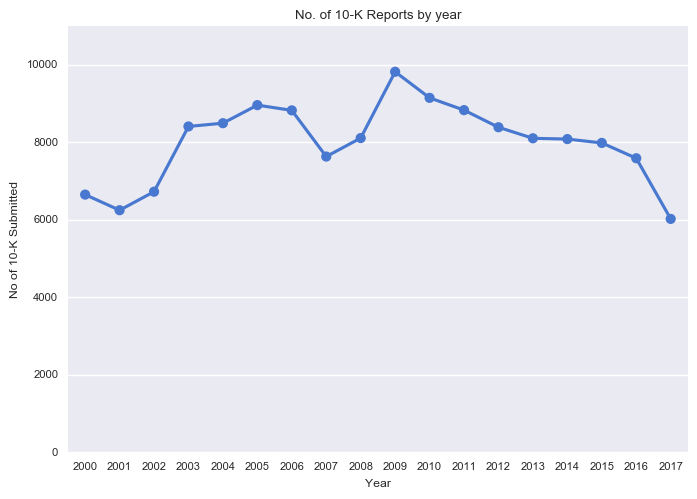

In [102]:
import seaborn as sns
current_palette_12 = sns.color_palette("Set1", n_colors=12, desat=.5)
sns.set(style="ticks", context="talk",palette=current_palette_12)
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=0.8,
                rc={"lines.linewidth": 2.5})

ax = sns.pointplot(x="year", y="company", data=year_agg,scale=0.5)
ax.set_title('No. of 10-K Reports by year')
ax.set(ylim=(0, 11000))
ax.set(xlabel='Year', ylabel='No of 10-K Submitted')

In [103]:
all_idx_listing.shape

(15170492, 8)